## Twitter - Sentiment Analysis

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import sklearn

### Read data

In [2]:
# Tweets data
df = pd.read_csv("Tweets.csv")

In [3]:
df.shape

(27481, 4)

The tweet dataset consists of 27480 records of tweets

In [4]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
# Check Null values
df.isnull().values.any()

True

In [6]:
# Recheck and drop null values
df = df.dropna()

sentiment
negative     7781
neutral     11117
positive     8582
dtype: int64


<AxesSubplot:>

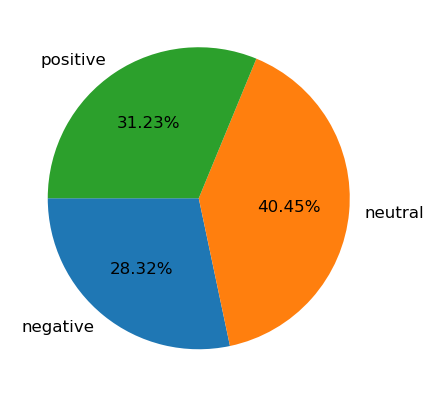

In [7]:
# Unique target values and their count
sentiment_counts = df.groupby(['sentiment']).size()
print(sentiment_counts)

# visualizing the sentiments
fig = plt.figure(figsize=(5,5), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.2f%%', startangle=180, fontsize=12, label="")

In [8]:
#Check the targets to be upsampled if any
df_major = df[df['sentiment'] == 'neutral']
df_minor1 = df[df['sentiment'] == 'positive']
df_minor2 = df[df['sentiment'] == 'negative']

In [9]:
print(df_major.shape, df_minor1.shape, df_minor2.shape)

(11117, 4) (8582, 4) (7781, 4)


In [10]:
# Upsample minority targets
def resample(sample):
    upsample = sklearn.utils.resample(sample, replace = True, n_samples = df_major.shape[0], random_state = 100)
    return upsample
    
pos_upsample = resample(df_minor1)
neg_upsample = resample(df_minor2)

sentiment
negative    11117
neutral     11117
positive    11117
dtype: int64


<AxesSubplot:>

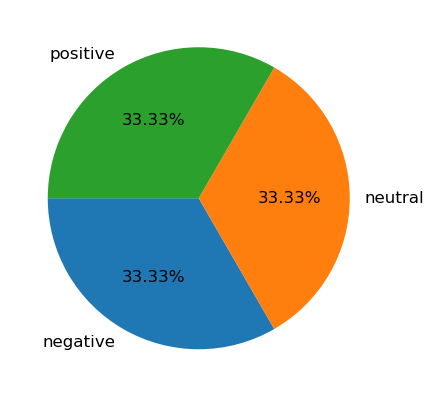

In [11]:
#Concatenate all the upsampled dataframes 

df_upsampled = pd.concat([df_major, pos_upsample, neg_upsample])

# Unique target values and their count
sntmnt_count_up = df_upsampled.groupby(['sentiment']).size()
print(sntmnt_count_up)

# visualizing the sentiments
fig = plt.figure(figsize=(5,5), dpi=100)
ax = plt.subplot(111)
sntmnt_count_up.plot.pie(ax=ax, autopct='%1.2f%%', startangle=180, fontsize=12, label="")

All the unique sentiments are equally sampled

In [12]:
print(df_major.shape, pos_upsample.shape, neg_upsample.shape)

(11117, 4) (11117, 4) (11117, 4)


In [13]:
#shuffle the rows

tweetdf = df_upsampled.sample(frac=1).reset_index(drop=True)
tweetdf

,textID,text,selected_text,sentiment
0,f3f729c014,not so good,not so good,negative
1,8e278328df,Came home after getting ratty in a shop with t...,ratty,negative
2,ea5251e093,wow...i have to many bookmarks...i just spent ...,good,positive
3,a34a224f03,Yes! Haha and then when he impaled himself wi...,Haha,positive
4,03fbd8f6b2,I wish I had Left 4 Dead. But first I`d need...,I wish I had Left 4 Dead. But first I`d need s...,neutral
...,...,...,...,...
33346,6fc13b7e51,dont make me sad... i do agree tho it does n...,e sad,negative
33347,284f573954,me neither at first...but u gotta go thru som...,.i almost burnt my house,negative
33348,4207ce064d,Probably the best birthday I`ve ever had. I go...,best,positive
33349,77b290dd59,a successful shopping day,successful,positive


In [14]:
#Partition the dataframe into x(input) and y(output)

x = tweetdf.iloc[:,[1]].copy()
y = tweetdf.iloc[:,[3]].copy()


In [15]:
x.tail()

,text
33346,dont make me sad... i do agree tho it does n...
33347,me neither at first...but u gotta go thru som...
33348,Probably the best birthday I`ve ever had. I go...
33349,a successful shopping day
33350,Class until 9:30 yes on a Friday night...


In [16]:
y.tail()

,sentiment
33346,negative
33347,negative
33348,positive
33349,positive
33350,neutral


### Text Preprocessing

In [17]:
# Function to clean the text

def clean_tweet(tweet):
    
    #remove links
    tweet_links = re.sub(r"http\S+"," ", tweet)
    tweet_links = re.sub(r"www.S+"," ", tweet_links)
    
    #remove punctuations
    tweet_punc = "".join([char for char in tweet_links if char not in string.punctuation])
    
    #tokenization
    tweet_token = word_tokenize(tweet_punc)
    
    #remove stopwords and lowercase
    stop_words = nltk.corpus.stopwords.words('english')
    tweet_stops = [word.lower() for word in tweet_token if word not in stop_words]
    
    #stemming and lemmetaization
    stm_lem = WordNetLemmatizer()
    cleaned_tweet = " ".join([stm_lem.lemmatize(word) for word in tweet_stops])
    
    return cleaned_tweet
    
    

In [18]:
# Check clean_tweet function

# original text
print("Original text:\n", x['text'][30])

# Cleaned text
print("cleaned text: \n", clean_tweet(x.text[30]))

Original text:
  : Hi, i think u should try Ph? in Vietnam, it`s really quite delicious
cleaned text: 
 hi think u try ph vietnam really quite delicious


In [19]:
#Clean all the tweets

index = 0
for tweet in x.text:
    x.text[index] = clean_tweet(tweet)
    index += 1

### Train & Implement Multinomial Naive Bayes model

In [20]:
#partition the dataframes into train and test dfs
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=72)

In [21]:
# Mapping the text ouput to numerical output

output_map = {'neutral': 0, 'positive': 1, 'negative': 2}
y_train = y_train['sentiment'].map(output_map)
y_test = y_test['sentiment'].map(output_map)

In [22]:
#tfidf vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvectorizer = TfidfVectorizer()

In [23]:
#convert the dataframe into tfidf matrix

tweet_tfidf_xdf = tfidfvectorizer.fit_transform(x_train['text'].tolist()).toarray()

In [24]:
tfidf_columns = tfidfvectorizer.get_feature_names()

In [25]:
# Train Multinomial Naive bayes model using training dataset

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=0.005)
model = nb.fit(tweet_tfidf_xdf, y_train)

In [26]:
# Predict the values

pred = nb.predict(tweet_tfidf_xdf)

In [27]:
#Evaluate scores

import sklearn.metrics as skm

print(skm.classification_report(y_train,pred))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      7859
           1       0.91      0.93      0.92      7752
           2       0.90      0.94      0.92      7734

    accuracy                           0.91     23345
   macro avg       0.91      0.91      0.91     23345
weighted avg       0.91      0.91      0.91     23345



**Accuracy:** 0.91


In [28]:
from sklearn.metrics import confusion_matrix

conf_mtx = confusion_matrix(y_train, pred)

conf_mtx_df = pd.DataFrame(conf_mtx,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
conf_mtx_df

,Negative,Neutral,Positive
Negative,6709,540,610
Neutral,339,7232,181
Positive,300,132,7302


**Sentiment Word Cloud**

In [29]:
import wordcloud
from wordcloud import WordCloud
from wordcloud import STOPWORDS

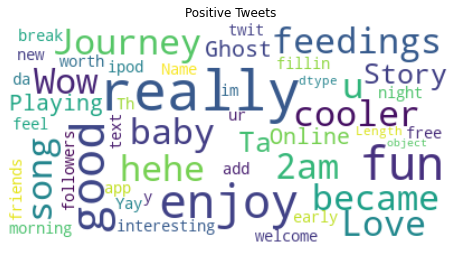

In [30]:
#Positive tweets word cloud

pos_tweets = df['text'][df['sentiment'] == 'positive']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
pos_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(pos_tweets))
plt.figure(figsize=(8,8))
plt.title("Positive Tweets")
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

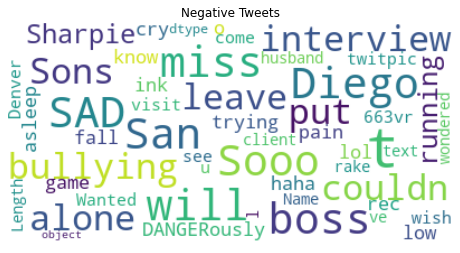

In [31]:
#Negative tweets word cloud

neg_tweets = df['text'][df['sentiment'] == 'negative']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
neg_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(neg_tweets))
plt.figure(figsize=(8,8))
plt.title("Negative Tweets")
plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

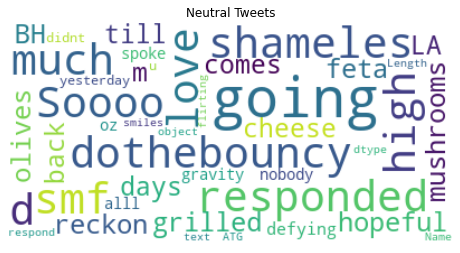

In [32]:
# Neutral tweets word cloud

neu_tweets = df['text'][df['sentiment'] == 'neutral']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
neu_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(neu_tweets))
plt.figure(figsize=(8,8))
plt.title("Neutral Tweets")
plt.imshow(neu_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()